In [1]:
import misleep
from itertools import groupby
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

e:\workplace\scripts\signal_process


In [2]:
data = misleep.load_mat(r'E:\workplace\EEGProcessing\00_DATA\OX_PFC\OX_4pin_6mA.mat')
anno = misleep.load_misleep_anno(r'E:\workplace\EEGProcessing\00_DATA\OX_PFC\OX_4pin_6mA.txt')
start_end_anno = anno.start_end

# Define a time range for consideration, 
# means every state's duration must be greater than the time
consider_time = 5
consider_channel = 'd465'
save_excel_path = r'E:\workplace\EEGProcessing\00_DATA\DA_PFC\A3_transition.xlsx'
save_fig_path = r'E:\workplace\EEGProcessing\00_DATA\DA_PFC\A3_transition.pdf'

In [3]:
start_end_anno

[[0.003, 34.669, 'NREM'],
 [34.669, 42.075, 'Wake'],
 [42.075, 129.749, 'NREM'],
 [129.749, 135.156, 'Wake'],
 [135.156, 160.001, 'NREM'],
 [160.001, 255.807, 'REM'],
 [255.807, 288.525, 'Wake'],
 [288.525, 399.631, 'NREM'],
 [399.631, 403.748, 'Wake'],
 [403.748, 548.757, 'NREM'],
 [548.757, 556.281, 'Wake'],
 [556.281, 651.038, 'NREM'],
 [651.038, 695.569, 'REM'],
 [695.569, 703.12, 'Wake'],
 [703.12, 711.548, 'NREM'],
 [711.548, 715.221, 'Wake'],
 [715.221, 737.578, 'NREM'],
 [737.578, 767.312, 'Wake']]

In [4]:
# find transition time point
transition_points = []

for idx, state in enumerate(start_end_anno[:-1]):
    next_state = start_end_anno[idx+1]
    # If the previous state and later state have overlap in a second, 
    # make it as a transition time point, 
    # the time point is average of the first state's end and next state's start
    if abs(state[1] - next_state[0]) <= 1:
        # The two states' time must larger than 5 seconds
        if state[1] - state[0] >= consider_time and next_state[1] - next_state[0] > consider_time:
            transition_points.append(
                [f'{state[2]}->{next_state[2]}', state[0], round((state[1] + next_state[0])/2, 3), next_state[1]]
            )

In [5]:
transition_points

[['NREM->Wake', 0.003, 34.669, 42.075],
 ['Wake->NREM', 34.669, 42.075, 129.749],
 ['NREM->Wake', 42.075, 129.749, 135.156],
 ['Wake->NREM', 129.749, 135.156, 160.001],
 ['NREM->REM', 135.156, 160.001, 255.807],
 ['REM->Wake', 160.001, 255.807, 288.525],
 ['Wake->NREM', 255.807, 288.525, 399.631],
 ['NREM->Wake', 403.748, 548.757, 556.281],
 ['Wake->NREM', 548.757, 556.281, 651.038],
 ['NREM->REM', 556.281, 651.038, 695.569],
 ['REM->Wake', 651.038, 695.569, 703.12],
 ['Wake->NREM', 695.569, 703.12, 711.548],
 ['NREM->Wake', 715.221, 737.578, 767.312]]

In [6]:
_sorted = sorted(transition_points, key=lambda x: x[0])
transition_points_group = [list(each) for _, each in groupby(_sorted, lambda x: x[0])]

In [7]:
transition_points_group

[[['NREM->REM', 135.156, 160.001, 255.807],
  ['NREM->REM', 556.281, 651.038, 695.569]],
 [['NREM->Wake', 0.003, 34.669, 42.075],
  ['NREM->Wake', 42.075, 129.749, 135.156],
  ['NREM->Wake', 403.748, 548.757, 556.281],
  ['NREM->Wake', 715.221, 737.578, 767.312]],
 [['REM->Wake', 160.001, 255.807, 288.525],
  ['REM->Wake', 651.038, 695.569, 703.12]],
 [['Wake->NREM', 34.669, 42.075, 129.749],
  ['Wake->NREM', 129.749, 135.156, 160.001],
  ['Wake->NREM', 255.807, 288.525, 399.631],
  ['Wake->NREM', 548.757, 556.281, 651.038],
  ['Wake->NREM', 695.569, 703.12, 711.548]]]

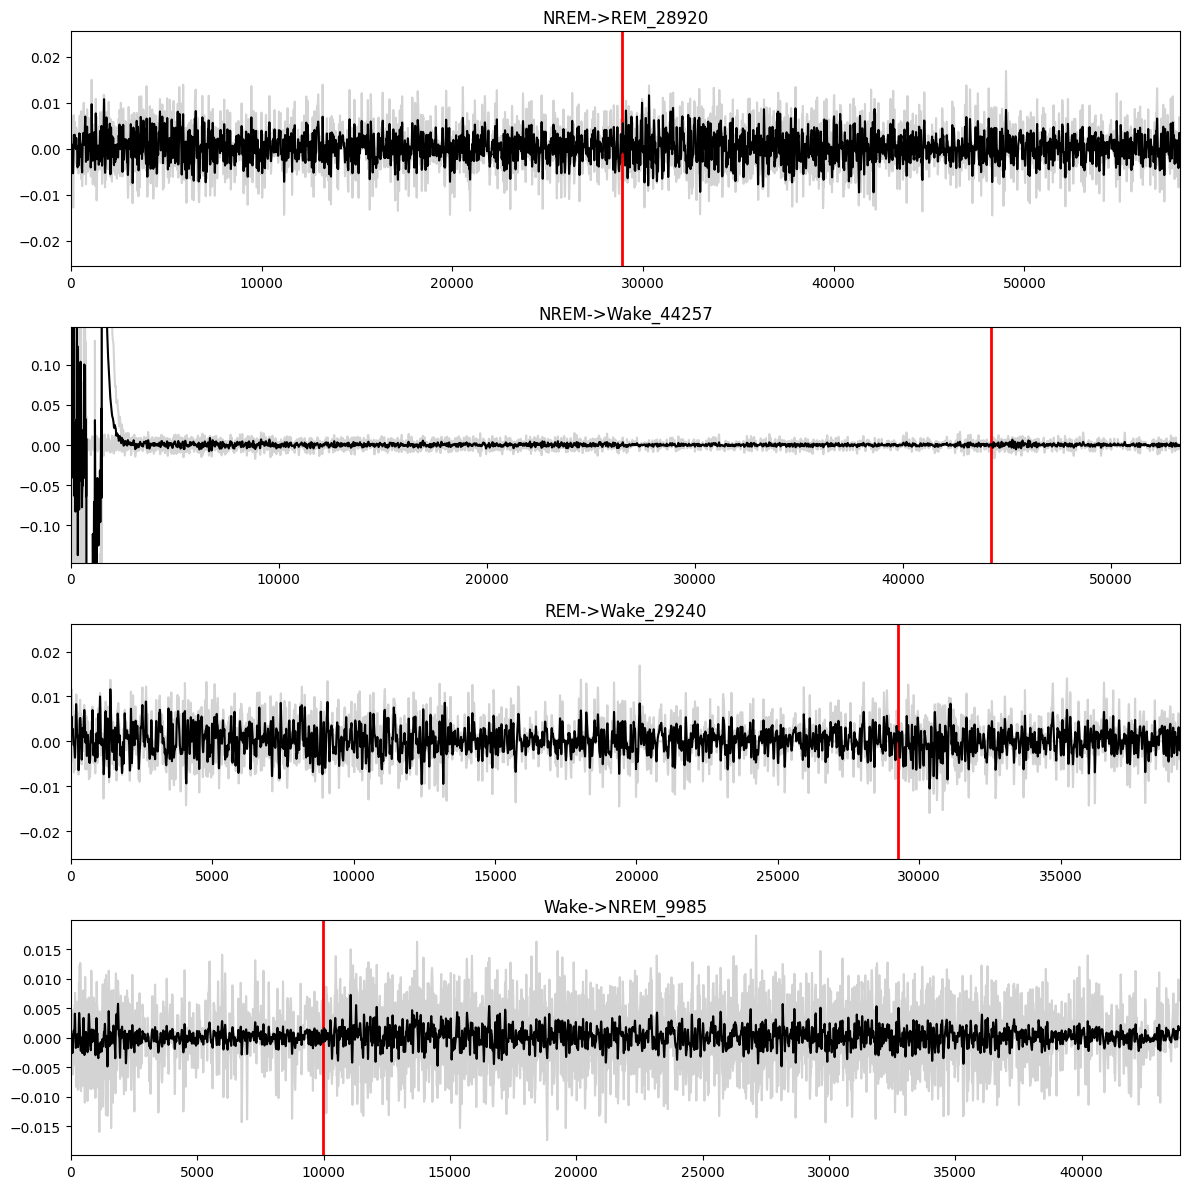

In [9]:
# Get data based on each group of transition time points
channel_midata = data.pick_chs(ch_names=[consider_channel])
channel_data = channel_midata.signals[0]
sf = channel_midata.sf[0]
writer = pd.ExcelWriter(save_excel_path)

# Draw
signal_figure = plt.figure(figsize=(12, 3*len(transition_points_group)))
signal_ax = signal_figure.subplots(nrows=len(transition_points_group))
signal_figure.set_tight_layout(True)

group_data = {}
for idx, transition_points in enumerate(transition_points_group):
    _name = transition_points[0][0]
    previous_max_length = max([int(each[2]*sf)-int(each[1]*sf) for each in transition_points])
    later_max_length = max([int(each[3]*sf)-int(each[2]*sf)for each in transition_points])
    _name = f'{_name}_{previous_max_length}'
    _temp_lst = []
    for each in transition_points:
        previous_data = channel_data[int(each[1]*sf): int(each[2]*sf)]
        previous_data_padded = np.pad(previous_data, (0, previous_max_length - len(previous_data)), 'constant', constant_values=0)
        later_data = channel_data[int(each[2]*sf): int(each[3]*sf)]
        later_data_padded = np.pad(later_data, (0, later_max_length - len(later_data)), 'constant', constant_values=0)
        _temp_lst.append(np.concatenate([previous_data_padded, later_data_padded]))

    _temp_lst = np.array(_temp_lst)

    [signal_ax[idx].plot(each, color='lightgray') for each in _temp_lst]
    signal_ax[idx].axvline(previous_max_length, color='red', linewidth=2)
    signal_ax[idx].set_xlim(0, previous_max_length+later_max_length)
    _max = np.mean(np.abs(_temp_lst))*10
    signal_ax[idx].set_ylim(-_max, _max)
    signal_ax[idx].set_title(_name)

    # calculate mean line
    _mean_group_data = np.mean(_temp_lst, axis=0)
    signal_ax[idx].plot(_mean_group_data, color='black')

    # signal_ax[idx].xaxis.set_ticks(
    #     [int(each * sf) for each in range(0, previous_max_length+later_max_length+1, 5)],
    #     np.arange(-previous_max_length, later_max_length+1, 5),
    # )

    _df = pd.DataFrame(data=np.array(_temp_lst).T,
        columns=['->'.join([str(_) for _ in each[1:]]) for each in transition_points])
    
    _df.to_excel(excel_writer=writer, sheet_name=_name, index=False)

signal_figure.savefig(save_fig_path, dpi=300)
writer.close()


In [53]:
['->'.join([str(_) for _ in each[1:]]) for each in transition_points]


['135.156->160.001->255.807', '556.281->651.038->695.569']

In [18]:
# Get data based on each group of transition time points
channel_midata = data.pick_chs(ch_names=[consider_channel])
channel_data = channel_midata.signals[0]
sf = channel_midata.sf[0]
writer = pd.ExcelWriter(save_excel_path)

signal_figure = plt.figure(figsize=(12, 3*len(transition_points_group)))
signal_ax = signal_figure.subplots(nrows=len(transition_points_group))
signal_figure.set_tight_layout(True)

for idx, group in enumerate(transition_points_group):
    _group_data = []
    _group_name = group[0][0]
    _group_time_points = [each[1] for each in group]
    for transition in _group_time_points:
        # Get data based on each transition time point
        start_time = transition - consider_time
        end_time = transition + consider_time
        _group_data.append(channel_data[int(start_time*sf): int(end_time*sf)])
    # align length of each transition data
    _length = min([len(each) for each in _group_data])
    _group_data = np.array([each[:_length] for each in _group_data])
    for each in _group_data:
        signal_ax[idx].plot(each, color='lightgray')
        signal_ax[idx].axvline(_length/2, color='red', linewidth=2)
        signal_ax[idx].set_xlim(0, _length)
        _max = np.max(np.abs(_group_data))*1.5
        signal_ax[idx].set_ylim(-_max, _max)
        signal_ax[idx].set_title(_group_name)

    # calculate mean line
    _mean_group_data = np.mean(_group_data, axis=0)
    signal_ax[idx].plot(_mean_group_data, color='black')

    signal_ax[idx].xaxis.set_ticks(
        [int(each * sf) for each in range(0, 2*consider_time+1, 1)],
        np.arange(-consider_time, consider_time+1, 1),
    )
        
    _df = pd.DataFrame(data=_group_data.T, columns=_group_time_points)
    _df.to_excel(excel_writer=writer, sheet_name=_group_name, index=False)

signal_figure.savefig(save_fig_path, dpi=300)
writer.close()

signal_figure.show()


IndexError: Zscore channel is not in the signal channels (['EEG', 'EMG_1', 'EMG_2', 'EMG_DIFF', 'REF', 'A405', 'A465', 'd465'])